## Prosjekt 1: Biofysikk
###### TMA4320 Introduksjon til vitenskapelige beregninger, vår 2022
###### Ethan Dias, Kristian Narten, Bettina Due


### Introduksjon
Organeller er elementer av en celle, hver med sine spesifikke oppgaver. Organellene samarbeider med og er avhengig av hverandre. De mest kjente organellene er adskilt fra cytosol ved en cellemembran, men i dette prosjektet skal vi undersøke dannelsen av membranløse strukturer, formet ved spontan væske-væske faseseparasjon fra cellens andre komponenter.

Vi skal undersøke de elektrostatiske kreftene som inngår i de membranløse organellene, der kreftenes rekkevidde er redusert i cellens vandige løsning, grunnet høy dielektrisk permittivitet. De elektriske kreftene virker mellom polymerer; molekyler med repeterende enheter - monomerer. Monomerene er bundet sammen med kovalente bindinger, og hver monomer har en ladning, som resulterer i en polymer med mange interraksjonspunkter -> multivalens.

Vi skal i dette prosjektet simulere monomer-systemer med $M$ positivt og $M$ negativt ladede monomerer, som kan bevege seg i et todimensjonalt, kvadratisk gitter tilsvarende en $N$x$N$ matrise. Vi benytter Metropolis-algoritmen, som er en Monte Carlo metode, for å beskrive monomer-systemer og deres utvikling over tid numerisk. Dette skal demonstrere betydningen av monomerenes interraksjonspunkter i formeringen av membranløse organeller i systemer bestående av motsatt ladede polymerer, formert av $L$ monomerer.

### Monomer-systemer

I første oppgave skal vi studere ulike egenskaper ved monomer-systemer, som vi i neste oppgave skal utnytte til å beskrive polymer-systemer. Vi starter med å simulere et enkelt system av monomerer i en løsning, tilsvarende en multivalens $L=1$. Under har vi importert enkelte funksjoner og definert parametere vi opererer med. Modellen som det numeriske systemet beskriver, gjør noen forenklinger av hensyn til programmets kjøretid blant annet ved å sette gitterkonstanten $a_1 = 23 \mu m$. Vi setter den relative permittiviteten lik den for vann, $\varepsilon_r=78$, da monomerene befinner seg i en vandig celleløsning.

In [1]:
# Importering av funksjoner og biblioteker

import numpy as np
import matplotlib.pyplot as plt
#fjern #-tegnet hvis numba ikke er installert
#%pip install numba
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# ignorerer enkelte advarsler
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
# Parametere

elem_charge = 1.60217662*10**(-19)     # elementærladning
eps_0 = (8.8541878128)*(10**(-12))     # elektrisk permittivitet i vakuum
eps_r = 78                             # relativ permittivitet for vann
a1 = 23*10**(-6)                       # gitterkonstant for monomer-system
a2 = 91*10**(-6)                       # gitterkonstant for polymer-system
# konstant benyttet i energiberegning for monomer-system
alpha1 = (elem_charge)**2/(4*np.pi*eps_0*eps_r*(a1**2)) 
# konstant benyttet i energiberegning for polymer-system
alpha2 = (elem_charge)**2/(4*np.pi*eps_0*eps_r*(a2**2)) 
k_b = 1.380649*10**(-23)               # boltzmanns konstant

Vi begynner med å implementere en funksjon som genererer et tilfeldig monomersystem. Funksjonen tar inn størrelsen $N$ og antall monomerer $M$ av hver ladning, og lager en $N$x$N$ matrise, med $M$ positive og $M$ negative monomerer plassert tilfeldig i gitteret.

In [3]:
# Funksjonen lager et tilfeldig NxN monomersystem med M positive og M negative monomerer
@jit(nopython=True)
def grid_random_monomers(N,M):
    grid = np.zeros((N,N))
    charge = (1,-1) # monomerene kan ha ladning +1 eller -1
    
    for k in range(2): # løkker gjennom to ganger for to ladninger
        count = 0
        while count != M: # tilfeldig plassering av M monomerer
            i = np.random.randint(N)
            j = np.random.randint(N)
        
            if grid[i][j] == 0: # sjekk at tilfeldig plassering ikke allerede er okkupert
                grid[i][j] = charge[k]
                count += 1
    return grid

For å kunne observere funksjonaliteten av koden vi skriver, lager vi en funksjon som kan visualisere et system. Funksjonen benytter matplotlib.pyplot sin innebygde colormesh-funksjon for å visualisere monomer-systemet som angis som parameter. I plottet representerer de gule og lilla boksene henholdsvis positivt og negativt ladde monomerer, mens det blå representerer den vandige celleløsningen med høy dielektrisk permittivitet.

In [4]:
# Funksjonen visualiserer angitt system ved bruk av innebygd plt.colormesh
def visualize_system(grid, fignr, title):
    # Henter ut N og M for angitt system
    N = len(grid[0])
    M = int(len(np.argwhere(grid))/2)
    
    plt.figure(fignr, figsize=(8,8)) # nummerering av figur, samt kvadratisk størrelse
    plt.ylim(N,0)
    plt.title(title)
    return plt.pcolormesh(grid) 

Et tilfeldig monomersystem generert med vår tidligere definerte funksjon vil dermed se følgende ut:

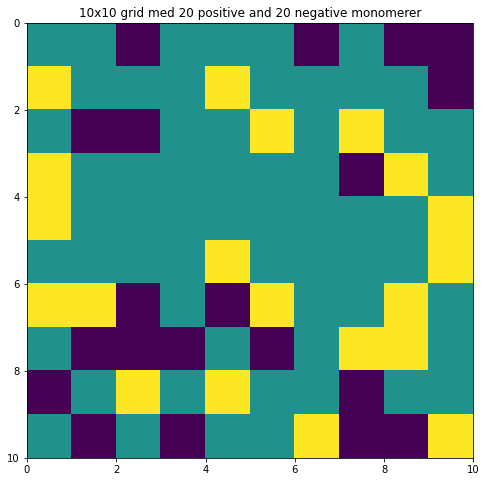

In [5]:
test_system = grid_random_monomers(10,20)
visualize_system(test_system, 0, "10x10 grid med 20 positive and 20 negative monomerer")

Monomer-systemets energi og monomerenes mulighet for å bevege seg avhenger av monomerens nærmeste naboer, altså potensielt andre monomerer som befinner seg over, under, til høyre og/eller til venstre. Det er derfor nyttig å definere en funksjon som finner koordinatene til de fire nærmeste naboene til en monomer som befinner seg i $N$x$N$ matrisen med indekser $i$ og $j$. Vi må her også ta hensyn til randbetingelser: vi antar periodiske randbetingelser, hvor vi ser for oss at gitterpunkter sør for den nederste raden tilsvarer den øverste raden, og tilsvarende for den ytterste høyre og venstre kolonnen. Systemet kan da anses å ha form som en torus.

In [6]:
# Funksjonen finner koordinatene til en angitt monomers nærmeste naboer
@jit(nopython=True)
def nearest_neighbors(N,i,j,grid):
    neighbor_array = np.zeros((4,2))
    # 0=left, 1=up, 2=right, 3=down
    if (j-1) < 0: j0 = N-1
    else: j0 = j-1
    if (i-1) < 0: i1 = N-1
    else: i1 = i-1
    if (j+1) >= N: j2 = 0
    else: j2 = j+1
    if (i+1) >= N: i3 = 0
    else: i3 = i+1
    # Her har vi tatt hånd om periodiske randbetingelser
        
    if grid[i,j0]!=0: neighbor_array[0] = [i,j0]
    else: neighbor_array[0] = -1
    if grid[i1,j]!=0: neighbor_array[1] = [i1,j]
    else: neighbor_array[1] = -1
    if grid[i,j2]!=0: neighbor_array[2] = [i,j2]
    else: neighbor_array[2] = -1
    if grid[i3,j]!=0: neighbor_array[3] = [i3,j]
    else: neighbor_array[3] = -1
    # Dersom det ikke eksisterer en nærmeste nabo i angitt retning, 
    # definerer vi den tomme koordinaten som [-1,-1]

    return neighbor_array

# Funksjonen returnerer en array med formen:
# [[koord. til venstre nabo], [koord. til øvre nabo], 
#  [koord. til høyre nabo], [koord. til nedre nabo]]

#nearest_neighbors[0] = koordinater til venstre nabo
#nearest_neighbors[1] = koordinater til øvre nabo
#nearest_neighbors[2] = koordinater til høyre nabo
#nearest_neighbors[3] = koordinater til nedre nabo
#nearest_neighbors[x][0] = i-koord til nabo
#nearest_neighbors[x][1] = j-koord til nabo

Vi kan så finne hva energien er for systemet. Grunnet celleløsningens høye dielektriske permittivitet, gjør vi en antagelse om at kun nærmeste naboer av monomerer bidrar til systemets energi. Energibidraget blir derfor lik 0 dersom nabokoordinaten er $[-1, -1]$, som tilsvarer at det ikke er en monomer-nabo i den retningen. Vi finner naboene fra den øvrige koden, og finner energien til systemet ved å se på interaksjoner mellom hver monomer og dens naboer.

Interaksjonen mellom to monomerer:

$$
V_{kl} = w_k w_l \frac{e^2}{4 \pi \varepsilon_0 \varepsilon_r a^2} \frac{a^2}{|r_k - r_l|}
= w_k w_l \alpha \frac{a^2}{|r_k - r_l|}
$$

Antar null interaksjon mellom monomerer som ikke er direkte ved siden av hverandre:

$$
\Rightarrow V_{kl} = w_k w_l \alpha \text{ dersom } r_k \text { og } r_l 
\text{ er nærmeste naboer, } 
$$
$$
\Rightarrow V_{kl}=0 \text{ ellers}
$$

Den totale energien for monomer-systemet blir da:

$$
E = \sum_{k,l} V_{kl} = \sum_{k,l} w_k w_l \alpha
$$

der $w_k$ og $w_l$ tilsvarer ladningen til hver av de to monomerene som bidrar til energien, med mulige verdier $+1$ eller $-1$, representert med verdien av de gitte indeksene for monomeren i gitter-matrisen.

In [7]:
# Funksjonen finner energien for et angitt system
@jit(nopython=True)
def system_energy(grid):
    energi = 0
    N = len(grid[0])
    for i in range(N):
        for j in range(N):
            # Vi løkker gjennom hver rad og hver kolonne i matrisen
            # Finner naboene til hvert element i matrisen
            neighbors = nearest_neighbors(N,i,j,grid)
            # Sjekker om det finnes en nabo til høyre
            if neighbors[2].all()!=(-1): 
                energi += grid[i,j]*grid[int(neighbors[2][0]),int(neighbors[2][1])]*alpha1
            # Sjekker om det finnes en nabo under
            if neighbors[3].all()!=(-1):
                energi += grid[i,j]*grid[int(neighbors[3][0]),int(neighbors[3][1])]*alpha1
    # Ved å kun regne ut energi mellom elementer til høyre eller under,
    # unngår vi å telle med interaksjoner i begge retninger 
    return energi

test_E = system_energy(test_system)
print(f"Systemet i figuren presentert ovenfor har en energi E = {test_E:.5e} J")

Systemet i figuren presentert ovenfor har en energi E = -1.50463e-36 J


Vi implementerer så Monte Carlo algoritmen for monomer-systemet vårt. Ett steg i prosessen tilsvarer å velge ut en tilfeldig monomer i systemet, og la den bevege seg i en tilfeldig valgt retning. Bevegelsen tillates hvis og bare hvis den resulterende totalenergien for den nye plasseringen er mindre enn den forrige, eller energidifferansen er mindre enn en bestemt tilfeldig grense, og monomeren vi ønsker å bevege ikke tar plassen til en annen monomer som allerede er på den nye plasseringen. Funksjonen tar inn antall ønskede steg, $N_s$, og temperaturen til systemet, $T$.

Fysiske systemer tenderer å innstille seg til en konfigurasjon som minimerer dets energi, så vi tillater derfor bevegelse av en monomer i en bestemt retning dersom:

$ \Delta E = E(\text{ny monomer posisjon})-E(\text{gammel monomer posisjon}) < 0 $

Vi må også tillate enkelte bevegelser som er energimessig ugunstig, dvs. $\Delta E>0$, da en monomer likevel kan forflytte seg grunnet termiske svingninger. Her ser vi konsekvensen av systemets temperatur, da vi også tillater bevegelse av en monomer i en bestemt retning dersom:

$exp[{-\frac{1}{k_B T} \cdot \Delta E}] = exp[-\beta \Delta E] > p $

der $p$ er et tilfeldig desimaltall mellom 0 og 1.

In [8]:
# Funksjonen flytter en monomer i angitt retning dersom ny plassering er ledig
@jit(nopython=True)
def move_monomer(grid, monomer_pos, direction):
    N = len(grid[0])
    # Finner koordinatene til naboen i ønsket retning
    neighbors = nearest_neighbors(N, monomer_pos[0], monomer_pos[1], grid)
    desired_neighbor_coordinate = neighbors[direction]

    # Flytter monomeren dersom naboposisjonen er ledig
    if int(desired_neighbor_coordinate[0])==(-1) and int(desired_neighbor_coordinate[1])==(-1):
        # 0=left, 1=up, 2=right, 3=down
        i = int(monomer_pos[0])
        j = int(monomer_pos[1])
        new_i = i
        new_j = j
        if direction==0:
            if j-1<0: new_j = N-1
            else: new_j = j-1
        elif direction==1:
            if i-1<0: new_i = N-1
            else: new_i = i-1
        elif direction==2:
            if j+1>=N: new_j = 0
            else: new_j = j+1
        elif direction==3:
            if i+1>=N: new_i = 0
            else: new_i = i+1
        # Tar hånd om periodiske randbetingelser

        new_grid = np.zeros((N,N))
        for k in range(N):
            for l in range(N):
                if k==i and l==j:
                    if i!=new_i: new_grid[k,l]=0
                    elif j!=new_j: new_grid[k,l]=0
                    else: new_grid[k,l]=grid[k,l]
                elif k==new_i and l==new_j:
                    if i!=new_i: new_grid[k,l]=grid[i,l]
                    elif j!=new_j: new_grid[k,l]=grid[k,j]
                    else: new_grid[k,l]=grid[k,l]
                else: new_grid[k,l]=grid[k,l]
    else: new_grid = grid
    return new_grid

# Funksjon for Monte Carlo prosessen for et monomer-system ved temperatur T
@jit(nopython=True)
def monte_carlo_monomers(N_s,N,M,T, n=0, t_equil=0, t_r=0):
    grid = grid_random_monomers(N,M) # Start-system
    eps = np.zeros(N_s)
    E = system_energy(grid) # Start-energi
    eps[0] = E
    beta = 1/(k_b*T)
    if n!=0:
        grid_array = np.zeros((n,N,N))
        grid_array[0] = grid
    for i in range(1, N_s): # utfører N_s Monte-Carlo-steg
        # Finner en tilfeldig monomer i systemet
        monomer_coordinates = np.argwhere(grid!=0)
        rand = np.random.randint(0,len(monomer_coordinates))
        rand_i = monomer_coordinates[rand][0]
        rand_j = monomer_coordinates[rand][1]
        # Finner en tilfeldig retning, kun horisontal eller vertikal bevegelse
        direction = np.random.randint(4)
        # 0=left, 1=up, 2=right, 3=down
        monomer_pos = [rand_i,rand_j]
        # Benytter øvrige funksjon for å flytte den tilfeldige monomeren
        new_grid = move_monomer(grid, monomer_pos, direction)
        # new_grid vil være lik grid dersom bevegelsen var ulovlig
        E_new = system_energy(new_grid)
        # E_new vil være lik E dersom bevegelsen var ulovlig
        # Tillater så bevegelsen dersom den møter de angitte energikravene
        if E_new < E:
            grid = new_grid
            E = E_new
        elif np.random.random() < (np.e**(-beta*(E_new - E))):
            grid = new_grid
            E = E_new
        eps[i] = E
        if n!=0:
            for t in range(n):
                if i == t_equil + t_r*t:
                    grid_array[t]=grid
    return grid, eps, grid_array
# Returnerer slutt-systemet, samt en array av utviklingen av energien for hvert steg
# grid_array inneholder konfigurasjonen etter (t_equil+t*t_r) steg for t fra 0 til n

Vi ønsker så å observere hvordan monomer-systemet vårt vil utvikle seg. Vi kjører to simulasjoner, begge med samme antall Monte-Carlo-steg $N_s$, størrelse $N$ og antall monomerer av hvert slag $M$, men ulike temperaturer $T_{\text{høy}}=500K$ og $T_{\text{lav}}=200K$. Vi visualiserer slutt-systemet av hver simulasjon, samt plotter energiutviklingen for begge systemene i samme figur som en funksjon av $t$, som i programmet tilsvarer antall MC-steg, men i virkeligheten kan anses som tid.

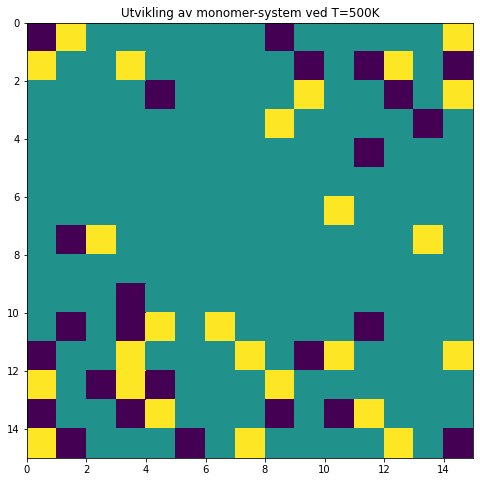

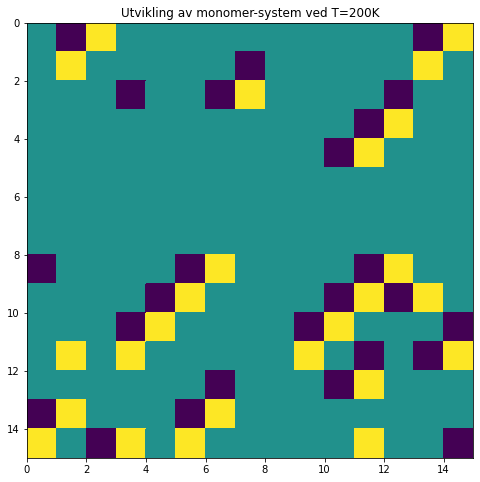

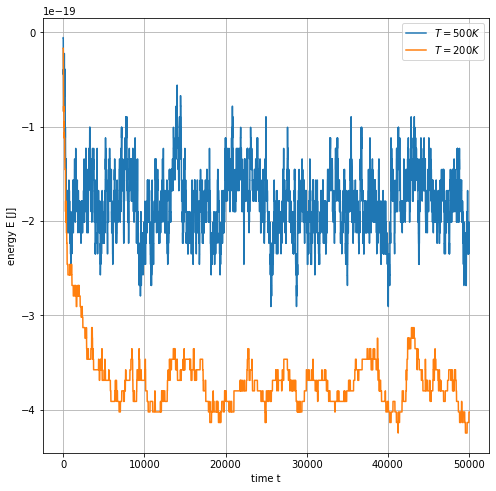

In [9]:
# Kjører to simulasjoner, like N_s, N og M, ulik T
N_s = 50000
N = 15
M = 25
T_h = 500
T_l = 200

# Lagrer konfigurasjonene og visualiserer dem for begge simulasjonene
grid_T_h, eps_T_h, gridarray_T_h = monte_carlo_monomers(N_s,N,M,T_h)
visualize_system(grid_T_h,1,"Utvikling av monomer-system ved T=500K")

grid_T_l, eps_T_l, gridarray_T_l = monte_carlo_monomers(N_s,N,M,T_l)
visualize_system(grid_T_l,2,"Utvikling av monomer-system ved T=200K")

# Plotter energiutviklingen over tid for begge simulasjonene i samme figur
plt.figure(3,figsize=(8,8))
t_energy = np.linspace(0, N_s, N_s)
plt.plot(t_energy, eps_T_h, label="$T = 500 K$")
plt.plot(t_energy, eps_T_l, label="$T = 200 K$")
plt.xlabel('time t')
plt.ylabel('energy E [J]')
plt.grid(True)
plt.legend()
plt.show()

Ved å lese av figuren for energiutviklingen, kan vi visuelt estimere hvor mange Monte-Carlo-steg som behøves før systemet når sin likevektstilstand, altså ved hvilken verdi av $t$ systemet oppnår en relativt periodisk svingning om en energi-middelverdi. For $T=500K$ angir vi denne verdien $t_{\text{equil,h}}\approx 10000$, og for $T=200K$ angir vi denne verdien $t_{\text{equil,l}}\approx 20000$. Vi observerer at

$$
T_{\text{høy}}>T_{\text{lav}} \quad \Rightarrow \quad
\beta_{\text{høy}}=\frac{1}{k_B T_{\text{høy}}} < \beta_{\text{lav}}=\frac{1}{k_B T_{\text{lav}}}
\quad \Rightarrow \quad exp[-\beta_{\text{høy}} \Delta E] > exp[-\beta_{\text{lav}} \Delta E]
$$

Altså: jo høyere temperatur systemet har, jo større sannsynlighet er det for at programmet vår genererer et tilfeldig tall lavere enn energigrensen, og dermed jo større sannsynlighet er det for at en monomer tillates å bevege seg i en energimessig ugunstig retning. Dermed synker antallet MC-steg nødvendig for å nå en likevektskonfigurasjon med økende temperatur, og det er derfor rimelig at $t_{\text{equil,h}}<t_{\text{equil,l}}$.

Nå som vi har fått et inntrykk av hvordan et monomer-system opererer, ønsker vi å undersøke formasjonen av aggregater; grupperinger av monomerer. Vi definerer en gruppering som en gruppe monomerer hvor det eksisterer en kontinuerlig sti mellom alle monomerene tilhørende gruppen, der stien er stykkevis horisontal eller vertikal, og ikke på tvers av den vandige celleløsningen.

Vi definerer derfor en ny matrise, av tilsvarende størrelse som monomer-posisjons-matrisen, som holder styr på hvor grupperingene befinner seg. På enhver posisjon det befinner seg en monomer i monomer-matrisen, vil det være et positivt tall i den tilsvarende posisjonen i grupperings-matrisen. Hver gruppering representeres da med et unikt positivt tall, så alle monomerer tilhørende den samme grupperingen vil ha det samme positive tallet i grupperings-matrisen.

Funksjonen under tar inn et monomer-system, og returnerer det tilhørende grupperings-gitteret. Vi benytter rekursjon for å kunne sjekke naboer til naboer til naboer, osv., og tildeler hver gruppe av sammenhengende monomerer en unik tallverdi. Vi visualiserer så monomer-systemet og det tilhørende grupperings-systemet for MC-simulasjonen ved den lave temperaturen $T_{\text{lav}}=200K$ under hverandre.

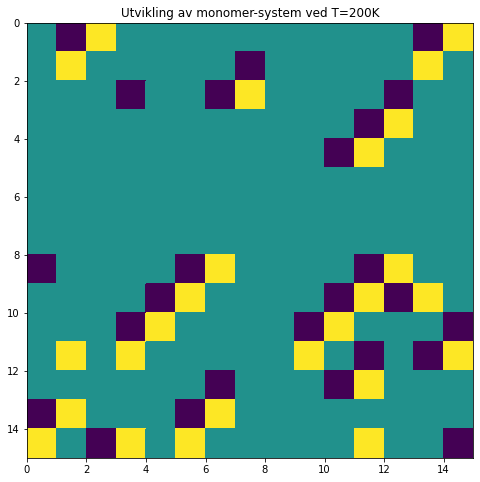

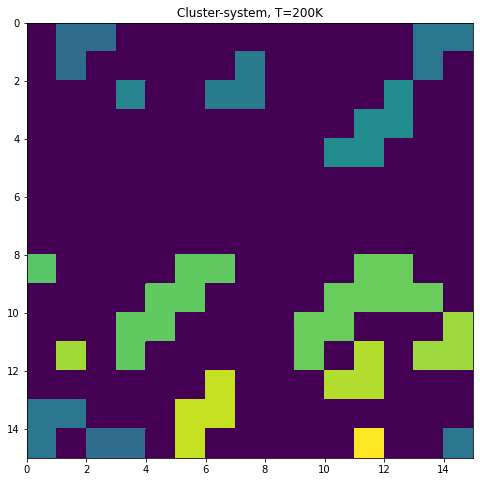

In [10]:
# Funksjonen sjekker naboer, naboer til naboer, osv., via rekursjon
# Gir alle monomerer tilhørende samme cluster samme cluster_id
@jit(nopython=True)
def check_neighboursv3(N,i,j,grid,new_grid,cluster_id,crash_id=0): 
    #crash id skulle hindre koden i å gjenta seg for mange ganger og kræsje
    if i == -1 or j == -1:
        return
    if grid[i,j] == 0: #hvis det gamle gridet ikke har en monomer
        new_grid[i,j] = -99 #det nye gridet blir kopiert
        # Velger -99 for å få stor nok kontrast mellom bakgrunnen og monomerene
        return
    if new_grid[i,j] != 0:
        return
#    print ('INDEKSER: ', i,j,' ', 'VERDI:', (grid[i,j]), ' ', 'cluster id: ', cluster_id)
    if grid[i,j] != 0: #hvis koordinatet på gridet er en monomer:
        new_grid[i,j] = cluster_id
#        print ('koordinat', i, j, 'har nå cluster_id:', cluster_id)
        all_neighbours = nearest_neighbors(N,i,j,grid)
#        print (i,j, 'har naboene', all_neighbours)
        for k in range (len(all_neighbours)):
            x_ny = int(all_neighbours[k,0])
            y_ny = int(all_neighbours[k,1])
            if new_grid[x_ny, y_ny] != 0: #sjekker om x,y i gridet allerede er sjekket
                continue # går til neste nabokoordinat, avslutter iterasjonen
            if x_ny == -1:
                continue
            if y_ny == -1:
                continue # gjør ingenting hvis naboen ikke er en monomer.
            second(N,x_ny,y_ny,grid,new_grid,cluster_id) 
        return #går ut av funksjonen etter alle neighbors er sjekket
    return #går ut av funksjonen hvis ingenting skjer

# jit aksepterer ikke direkte rekursjon, må gå gjennom noen mellomfunksjoner
@jit(nopython=True)
def second(N,x_ny,y_ny,grid,new_grid,cluster_id):
    return third(N,x_ny,y_ny,grid,new_grid,cluster_id)
@jit(nopython=True)
def third(N,x_ny,y_ny,grid,new_grid,cluster_id):
    return check_neighboursv3(N,x_ny,y_ny,grid,new_grid,cluster_id)

# Funksjonen tar inn et grid med positive og negative monomerer
# Returnerer et cluster-grid hvor monomerer i samme cluster får samme farge
@jit(nopython=True)
def cluster_gridv3(grid):
    N = len(grid[0])
    cluster_id = 1
    new_grid = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if new_grid[i,j] == 0: #hvis indeksene i,j ikke allerede er sjekket fra før:
                check_neighboursv3(N,i,j,grid,new_grid,cluster_id)
                cluster_id += 1
    return new_grid  

# Monomersystem og tilhørende clustergrid etter MC-simulasjon ved 200K
T_l_MC_clustergrid = cluster_gridv3(grid_T_l)
visualize_system(grid_T_l,4, "Utvikling av monomer-system ved T=200K")
visualize_system(T_l_MC_clustergrid,5,"Cluster-system, T=200K")

En interessant fysisk størrelse å studere for et monomer-system er den middelverdige størrelsen av grupperingene, $\langle d \rangle$. Størrelsen av en gruppering defineres som antall monomerer som utgjør grupperingen. Vi må først la systemet nå sin likevekt før vi utfører målingene, så vi benytter MC-funksjonen på et monomer-system, der vi lar 

$t_{\text{equil}}(T) = t_{\text{max }} exp(-s(T - T_l))+C$

som er et smult optimistisk estimat for antall MC-steg nødvendig, men garanterer at systemet har nått sin likevekt, samt en rimelig kjøretid. Når vi har utført $t_{\text{equil}}$ MC-steg, kan vi beregne $\langle d \rangle$ som en funksjon av *grid($t$)* ved ulike $t$. Vi starter på $t=t_{\text{equil}}$, og beregner gjennomsnittet $\overline{d}$ etter $t_r$ MC-steg $n$ ganger. Til slutt kan vi estimere middelverdien $\langle d \rangle$ som $(\sum\overline{d})/n$.

Vi ser på hvordan klynge-størrelsen vil avhenge av temperatur, ved å plotte $\langle d \rangle$ som en funksjon av 10 likefordelte temperaturer mellom $T_l = 100 K$ og $T_h = 1000 K$. Vi kjører simulasjonen to ganger for å se om noen avvik oppstår.

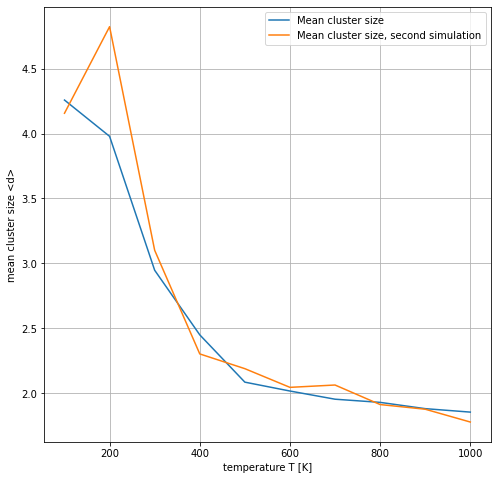

In [11]:
# Funksjonen tar inn et cluster-grid av et monomer-system
# Returnerer gjennomsnittlig clusterstørrelse i monomer-systemet
@jit(nopython=True)
def mean_cluster_size(grid):
    cluster_ids = []
    N = len(grid[0])
    for i in range (N):
        for j in range(N):
            if grid[i,j] > 0:
                cluster_ids.append(grid[i,j])
    different_cluster_ids = set(cluster_ids) #hvor mange forskjellige clustere det er
    antall_clusters = (len(different_cluster_ids)) #totalt antall clustere
    cluster_sizes = []
    sum_cluster_sizes = 0
    for element in different_cluster_ids:
        cluster_count = cluster_ids.count(element)
        cluster_sizes.append(cluster_count)
        sum_cluster_sizes += cluster_count
    return (sum_cluster_sizes/antall_clusters)

# Funksjonen beregner den middelverdige clusterstørrelsen 
# Estimeres å være lik "gjennomsnittet av gjennomsnittene"
@jit(nopython=True)
def total_mean_cluster_size():
    # Parameter-verdier vi benytter
    N = 15
    M = 25
    T_l = 100
    T_h = 1000
    T_array = np.linspace(T_l,T_h, 10)
    t_max = 10000 #legg til en ekstra 0 når koden fungerer mer effektivt!!!!!!!!
    s = (1/200)
    C = 10000
    t_r = 1000
    n = 30
    d = np.zeros((len(T_array),n))
    avg_size = np.zeros(len(T_array))

    # Definerer uttrykket for t_equil
    def t_eq(T):
        return (t_max*(np.e**(-s*(T-T_l)))+C)

    # Finner middelverdig clusterstørrelse for hver av temperaturene
    for m in range(len(T_array)):
        t_equil = int(np.ceil(t_eq(T_array[m]))) # Steg nødvendig for likevekt
        N_s = int(t_equil + t_r*n) # Totalt antall MC-steg
        grid_mc, eps_mc, grid_array = monte_carlo_monomers(N_s,N,M,int(T_array[m]),n,t_equil,t_r)
        for t in range(len(grid_array)):
            clustergrid_mc_step = cluster_gridv3(grid_array[t])
            d[m,t] = mean_cluster_size(clustergrid_mc_step)
        sum_d=0
        for x in range(len(d[m])): sum_d+=d[m,x]
        avg_size[m] = (sum_d)/n
    return T_array, avg_size

T_array, avg_size = total_mean_cluster_size()
T_array_new, avg_size_new = total_mean_cluster_size()
# Plotter "mean-cluster-size" mht. temperatur for to simulasjoner
plt.figure(6,figsize=(8,8))
plt.plot(T_array, avg_size, label="Mean cluster size")
plt.plot(T_array_new, avg_size_new, label="Mean cluster size, second simulation")
plt.xlabel('temperature T [K]')
plt.ylabel('mean cluster size <d>')
plt.grid(True)
plt.legend()
plt.show()

Vi observerer at $\langle d \rangle$ minsker for økende $T$. Vi kan observere dette også fra de to Monte-Carlo-simulasjonene for én lav og én høy temperatur. Dette kan forklares av samme resonnement som hvorfor $t_{\text{equil,h}}>t_{\text{equil,l}}$, nemlig at høyere temperatur gir høyere termisk energi, som gir større termiske svingninger, slik at det er større sannsynlighet for at monomerer kan bevege seg i en energimessig ugunstig retning. Dette resulteres i at færre monomerer vil klynge seg sammen for å minimere systemets totale energi, og vi får dermed et lavere estimat for den forventede klynge-størrelsen.

Jo flere målinger $n$ vi utfører, jo mer pålitelige blir resultatene våre, men jo lenger kjøretid påkreves. Hvis vi forsøker å utføre simulasjonen flere ganger, oppdager vi et større avvik mellom forventet klynge-størrelse ved lave temperaturer. Vi observerer derfor at initialbetingelsene, altså det tilfeldige monomer-systemet som genereres, vil ha større betydning for den forventede klynge-størrelsen ved lavere temperaturer enn for høyere temperaturer. Ved enkelte simulasjoner observerte vi også at $\langle d \rangle$ kunne øke fra én lavere $T$ til én høyere $T$, noe som motstrider intuisjonen vår. Dette kan forklares ved at sannsynligheten for at enkelt-monomerer, med lang avstand til andre monomerer, vil bevege seg lengre distanser blir lavere jo mindre temperaturen er. Resultatene vil derfor ha større avhengighet av hvor tett monomerene plasseres tilfeldig ved initialisering av systemet for lave temperaturer enn for høye temperaturer.

### Polymer-systemer

Monomerer opptrer sjeldent alene. De vil som oftest interagere med andre monomerer, og binde seg sammen til polymerer. Denne tendensen ble vist i simulasjonene i for monomer-systemene, ved at monomerene ofte grupperte seg sammen i klynger for å senke det totale potensialet, og dermed den totale energien i systemet. I polymerer er monomerene bundet sammen med kovalente bindinger, hvor vi i denne oppgaven skal observere hvordan tilkoblingene påvirker aggregat-formering til klynger. Vi vil så evaluere hvordan polymerenes fleksibilitet påvirker denne grupperingen, ved å tillate bevegelser av medium fleksibilitet i polymer-gitteret.

Vi beholder den vandige celleløsningens relative dielektriske permittivitet $\varepsilon_r=78$, men lar nå gitterkonstanten øke til $a_2 = 91 \mu m$.

Vi begynner som for monomer-systemet med å implementere en funksjon som genererer et tilfeldig polymersystem. Funksjonen tar inn størrelsen $N$, antall polymerer $M$ av hver ladning, og antall monomerer per polymer $L$. Funksjonen returnerer en $N$x$N$ matrise, med $2M$ tilfeldig plasserte polymerer, hver med en multivalens $L$.

In [12]:
#Funksjon som tar in grid, koordiater og retning for å sjekke om det er ledig plass
@jit(nopython=True)
def valid_expand(grid,i,j,direction):
    N = len(grid)                     #retningen fra koordinatene
    
    if direction == 0: #flytter koordinatene i gitt retning (0=høyre, 1=venstre, 2=opp, 3=ned)
        j-=1
    elif direction == 1:
        i-=1
    elif direction == 2:
        j+=1
    elif direction == 3:
        i+=1
    
    if j == -1: # Her har vi tatt hånd om periodiske randbetingelser
        j = N-1
    elif i == -1:
        i = N-1
    elif j == N:
        j = 0
    elif i == N:
        i = 0

    if grid[i][j] == 0: 
        #Hvis ledig posisjon returner funksjonen true og koordinater hvor vi kan plassere
        return True, i, j
    else: #Ellers gir den false istedenfor (og koordinater slik at det alltid er like mange outputs)
        return False, i, j

In [13]:
# Funksjon for å generere et NxN array med 2M polymerer, 
# M med postiv ladning og M med negativ, og alle polymerer har multivalens L
@jit(nopython=True)
def grid_random_polymers(N,M,L): 
    grid = np.zeros((N,N))
    charge = (1,-1) 
    polymers = [] #Tom grid som skal fylles opp med 2M L*2 arrays,

    # Kjører prosesses to ganger, en for de M positive monomerene og en for de M negative
    for k in range(2):
        count = 0 #Count for hvor mange polymerer som er laget
        while count != M: #Loop for å lage M polymerer
            i = np.random.randint(N) #Velger et tilfeldig startpunkt
            j = np.random.randint(N)
            
            #sjekker at den tilfeldige posisjonen er ledig, hvis ikke finner en ny
            while grid[i,j] != 0:
                i = np.random.randint(N) 
                j = np.random.randint(N)
                
            grid[i,j] = charge[k] #Setter ladningen til den ledige startposisjonen
            count += 1

            monomer_pos_array = np.zeros((L,2)) #L*2 array for koordinater til alle L monomerer i en polymer
            monomer_pos_array[0] = [i,j] #Setter startposisjonen som første element
            
            l=0 #Count for hvor mange monomerer som er i polymeren
            failsafe = 0 #Count for hvor mange ganger det blir prøvd å plassere en monomer
                         #Brukes til å avbryte hvis en polymer ikke har nok plass
            while l<L-1: #Loop for å plassere L-1 flere monomerer slik at det blir en polymer
                rand = np.random.randint(0,l+1) #Velger en tilfeldig monomer i polymeren
                i = int(monomer_pos_array[rand][0]) 
                j = int(monomer_pos_array[rand][1])
                
                #Tilfeldig retning: 0=høyre, 1=venstre, 2=opp, 3=ned
                direction = np.random.randint(4) 
                #Sjekker at det er plass til ny monomer
                valid, temp_i, temp_j = valid_expand(grid,i,j,direction)
                #Om det er plass, plasseres en monomer der. Hvis ikke går loopen om igjen
                if valid == True: 
                    i = temp_i 
                    j = temp_j
                    l += 1
                    
                    grid[i][j] = charge[k]
                    monomer_pos_array[l,0]=i 
                    monomer_pos_array[l,1]=j
                
                failsafe +=1
                #Avbryter om loopen bruker mange fler iterasjoner enn forventet, f. eks. når et polymer blir fast inni et annet
                if failsafe >= L*10**3: 
                    print('Polymer nummer ',count,' med ladning ',charge[k],' ble sittende fast')
                    break
            #Legger til den ferdige polymerens koordinater i array
            polymers.append(monomer_pos_array)
    return grid, polymers

Vi visualiserer så et tilfeldig generert polymer-system.

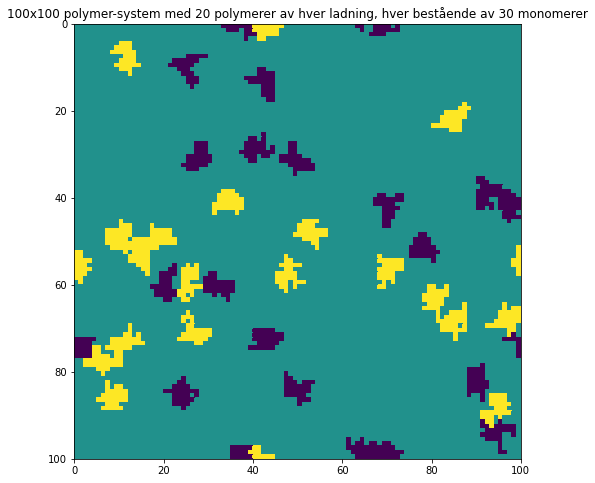

In [14]:
grid51, polymers51 = grid_random_polymers(100,20,30)
visualize_system(grid51,7, '100x100 polymer-system med 20 polymerer av hver ladning, hver bestående av 30 monomerer')

Vi utvider energi-funksjonen fra tidligere til å kunne beregne energien av et polymer-system. Vi neglisjerer interaksjonen mellom monomerer tilhørende samme polymer, da monomerene er bundet sammen med kovalente bindinger, samt antar null interaksjon mellom polymerer uten noen interaksjonspunkter direkte ved siden av hverandre. Vi undersøker altså kun bidrag til energien fra direkte interaksjoner mellom ulike polymerer, og benytter samme formel for beregning av energien som for monomer-systemet:

$$
E = \sum_{k,l} V_{kl} = \sum_{k,l} w_k w_l \alpha
$$

der $\alpha$ nå inneholder den høyere gitterkonstanten, og verdiene $w_k$ og $w_l$ tilsvarer verdien/ladningen av polymerene som samhandler i gitteret. 

In [15]:
# Funksjonen finner energien for et angitt system
@jit(nopython=True)
def system_energy_polymers(grid):
    energi = 0
    N = len(grid[0])
    # Vi løkker gjennom hver rad og hver kolonne i matrisen
    for i in range(N):
        for j in range(N):
            # finner cluster_iden til koordinatet vi skal sjekke rundt
            cluster_id_polymer = grid[i,j] 
            # Finner naboene til hvert element i matrisen
            neighbors = nearest_neighbors(N,i,j,grid)
            nearest_neighbors_coordinate2x = int(neighbors[2,0])
            nearest_neighbors_coordinate2y = int(neighbors[2,1])
            nearest_neighbors_coordinate3x = int(neighbors[3,0])
            nearest_neighbors_coordinate3y = int(neighbors[3,1])
            #finner cluster_id til naboene til høyre og under til koordinatet
            nabo2_cluster_id = grid[nearest_neighbors_coordinate2x,nearest_neighbors_coordinate2y]
            nabo3_cluster_id = grid[nearest_neighbors_coordinate3x,nearest_neighbors_coordinate3y]
            # Legger kun til energien hvis naboen har ulik cluster_id og er en monomer (grid[i,j]!= -1)
            # Sjekker om det finnes en nabo til høyre
            if neighbors[2].all()!=(-1) and nabo2_cluster_id != cluster_id_polymer: 
                energi += grid[i,j]*grid[int(neighbors[2][0]),int(neighbors[2][1])]*alpha2
            # Sjekker om det finnes en nabo under
            if neighbors[3].all()!=(-1) and nabo3_cluster_id != cluster_id_polymer:
                energi += grid[i,j]*grid[int(neighbors[3][0]),int(neighbors[3][1])]*alpha2
    # Ved å kun regne ut energi mellom elementer til høyre eller under,
    # unngår vi å telle med interaksjoner i begge retninger 
    return energi

I virkeligheten kan polymerer bevege seg fleksibelt i alle retninger, bøyes og vri seg rundt, men det er komplisert å implementere en full realisering av polymerers bevegelighet numerisk. Siden vi er begrenset til et gitter-system, ser vi kun på vertikale eller horisontale bevegelser, og ser bort fra tredimensjonal rotasjon. Vi skal her studere to grader av fleksibilitet i bevegelsen av polymerer, først en rigid bevegelse, så en bevegelse av medium fleksibilitet. 

En rigid bevegelse følger kravet om at alle monomerene tilhørende samme polymer beveges i samme retning. Dersom en eller flere av monomerene kolliderer med en annet polymer, avviser vi bevegelsen, og hele polymeren forblir i sin utgangsposisjon. Vi implementerer her en funksjon for rigid bevegelse av en bestemt polymer i en spesifisert retning.

In [16]:
# Funksjon for rigid bevegelse av en polymer i en bestemt retning
# Outputet fra funksjonen må brukes for flere bevegelser
@jit(nopython=True)
def move_rigid(grid, polymer, direction): 
    #direction: 0 = venstre, 1 = opp, 2 = høyre, 3 = ned
    N = len(grid)
    L = len(polymer)
    # Lagrer en backup av grid og polymerer
    new_grid = grid.copy() 
    new_polymer = polymer.copy()
    # finner ladningen til polymeren vi vil flytte
    charge1 = grid[int(polymer[0,0]),int(polymer[0,1])]
    cancel = np.ones(L,dtype=np.bool_) 
    # boolean array med L True elementer, en til hver monomer i polymeren
    
    #Fjerner polymer vi vil flytte slik at den ikke blir blokkert av seg selv
    for k in range(L): 
        i=int(new_polymer[k,0])
        j=int(new_polymer[k,1])
        new_grid[i,j] = 0
    
    #Ser om noen av de tidligere monomer-posisjonene har naboer i retningen vi vil
    for k in range(L): 
        i=int(new_polymer[k,0])
        j=int(new_polymer[k,1])
        if nearest_neighbors(N,i,j,new_grid)[direction][0] !=(-1) or nearest_neighbors(N,i,j,new_grid)[direction][1] != (-1):
            # Endrer element k i cancel for å si at bevegelsen vil bli blokkert
            cancel[k] = False
        else:
            continue
    
    Cancel=True
    for c in range(len(cancel)): 
        if cancel[c]==False: Cancel=False #Ser en av monomerene vil bli blokkert
    
    if Cancel == False: #Plasserer polymeren tilbake om det er en blokkert bevegelse
        for k in range(L):
            i=int(new_polymer[k,0])
            j=int(new_polymer[k,1])
            new_grid[i,j] = charge1
    else: #Hvis ingen blir blokkert, beveger den polymeren
        for k in range(L): 
            i=int(new_polymer[k,0])
            j=int(new_polymer[k,1])
            if direction == 0:
                if (j-1)<0: j=N-1
                else: j-=1
            elif direction == 1:
                if (i-1)<0: i=N-1
                else: i-=1
            elif direction == 2:
                if (j+1)>=N: j=0
                else: j+=1
            elif direction == 3:
                if (i+1)>=N: i=0
                else: i += 1
            new_grid[i,j] = charge1
            new_polymer[k,0] = i
            new_polymer[k,1] = j
    
    return new_grid, new_polymer

Nå som vi kan definere energien i et polymer-system og bevegelse av polymerer, kan vi implementere Monte Carlo algoritmen for å studere utviklingen av polymer-systemer. Vi benytter samme betingelser for en tillatt bevegelse, nemlig dersom den resulterer i en lavere totalenergi, eller hvis differansen mellom totalenergien for det nye og gamle systemet er under en bestemt grense. Vi utfører så en MC-simulasjon ved $T=200K$ ved bruk av rigid bevegelse for polymerene.

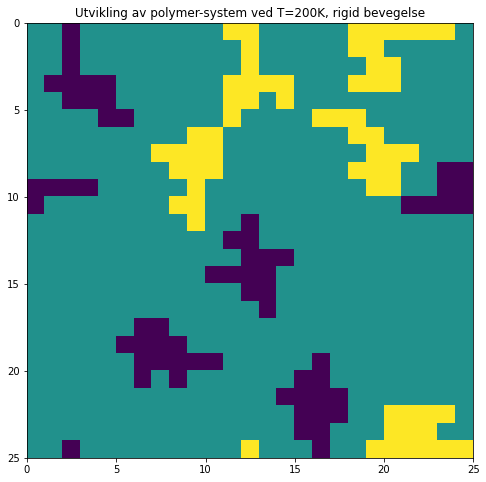

In [17]:
# Funksjon for Monte Carlo prosessen for et polymer-system ved temperatur T
@jit(nopython=True)
def monte_carlo_polymers(N_s,N,M,L,T,move_type,n=0,t_equil=0,t_r=0): 
    # move_type lar oss benytte samme funksjon ved enten rigid eller flexibel move
    grid, polymers = grid_random_polymers(N,M,L) # Start-system
    eps = np.zeros(N_s)
    E = system_energy_polymers(grid) # Start-energi
    eps[0] = E
    beta = 1/(k_b*T)
    if n!=0:
        grid_array = np.zeros((n,N,N))
        grid_array[0] = grid
    for i in range(1, N_s): # utfører N_s Monte-Carlo-steg
        # Finner en tilfeldig polymer i systemet
        rand = np.random.randint(0,len(polymers))
        rand_polymer = polymers[rand]
        # Finner en tilfeldig retning, kun horisontal eller vertikal bevegelse
        # 0=left, 1=up, 2=right, 3=down
        direction = np.random.randint(4)
        # Benytter øvrige funksjon for å flytte den tilfeldige polymeren
        new_grid, new_polymer = move_type(grid, rand_polymer, direction)
        # new_grid vil være lik grid dersom bevegelsen var ulovlig
        E_new = system_energy_polymers(new_grid)
        # E_new vil være lik E dersom bevegelsen var ulovlig
        # Tillater så bevegelsen dersom den møter de angitte energikravene
        if E_new < E:
            grid = new_grid
            polymers[rand] = new_polymer
            E = E_new
        elif np.random.random() < (np.e**(-beta*(E_new - E))):
            grid = new_grid
            polymers[rand] = new_polymer
            E = E_new
        eps[i] = E
        if n!=0:
            for t in range(n):
                if i == t_equil + t_r*t:
                    grid_array[t]=grid
    return grid, polymers, eps, grid_array
# Returnerer slutt-systemet, slutt-polymerene, og utviklingen av energien for hvert steg
# grid_array inneholder konfigurasjonen etter (t_equil+t*t_r) steg for t fra 0 til n

# Kjører en MC-simulasjon med følgende parametere
N_s = 30000
N = 25            # Fritt valg
M = 5             # 2 < M < 6
L = 13            # L > 10
T = 200
# Benytter rigid move
grid_mc_rigid, polymers_mc_rigid, eps_mc_rigid, grid_array_rigid = monte_carlo_polymers(N_s,N,M,L,T,move_rigid)
visualize_system(grid_mc_rigid,9,"Utvikling av polymer-system ved T=200K, rigid bevegelse")

Liknende monomersystemet, vil vi observere at polymerer av motsatt ladning vil begynne å klynge seg sammen med så mange interaksjonspunkter som mulig, da en slik oppførsel resulterer i en minimal energi. Med rigid bevegelse oppstår det begrensninger for hvor mange interaksjonspunkter to polymerer kan ha, så det vil være noe tomrom av celleløsning mellom polymerene i klyngene. Da det nå kreves en god del flere betingelser for hvordan polymerene kan bevege seg og hvilke interaksjoner som teller med i energiberegningen, vil kjøretiden for koden være noe høyere enn for monomer-systemet.

En rigid bevegelse er lettere å implementere numerisk, men er en mindre realistisk simulering av hvordan polymerer faktisk kan bevege seg innad i en celle. Vi implementerer derfor videre en bevegelse med medium fleksibilitet i en spesifisert retning. Bevegelsen følger kravet om at alle monomerer tilhørende samme polymer forsøkes å beveges ett steg i samme horisontale eller vertikale retning. Dersom noen av monomerene i en rad eller kolonne kolliderer med en annet polymer, forblir alle monomerene i de radene/kolonnene som kolliderer i sin utgangsposisjon, mens alle kollisjons-frie rader/kolonner tillates å forflyttes.

Når en bevegelse av medium fleksibilitet gjennomføres, er det en sjanse for at polymeren blir ødelagt. Hvis den kontinuerlige stykkevis horisontale eller vertikale stien mellom noen av monomerene tilhørende samme polymer ødelegges, sier vi at polymeren er ødelagt. Vi lager derfor en funksjon som sjekker om en polymer er ødelagt, og benytter denne for å forbedre implementasjonen av bevegelse med medium fleksibilitet. Vi må altså også betinge at bevegelsen kun tillates dersom den forflyttede polymeren ikke blir ødelagt, ellers forblir polymeren i sin utgangsposisjon.

In [18]:
# Funksjonen finner antall clustere i et polymersystem
@jit(nopython=True)
def number_of_clusters(grid):
    N = len(grid[0])
    cluster_ids = np.zeros(N*N)
    k=0
    for i in range (N):
        for j in range(N):
            if grid[i,j] > 0:
                cluster_ids[k]=(grid[i,j]) 
                #k blir antall ganger loopen har iterert gjennom en polymerkoordinat
                k+=1
    different_cluster_ids = set(cluster_ids) #hvor mange forskjellige clustere det er
    antall_clusters = (len(different_cluster_ids))-1 #antall clustere totalt
    return (antall_clusters)

In [19]:
# Funksjonen sjekker om en spesifikk polymer i et system er ødelagt
@jit(nopython=True)
def check_broken_single_polymer(polymer, grid):
    N = len(grid[0])
    new_grid = np.zeros((N,N)) #lager et nytt grid og limer inn polymeren som er inputet
    for j in range(len(polymer)):
        x = int(polymer[j][0])
        y = int(polymer[j][1])
        new_grid[x,y] = 1 
        #har verdien 1 på det nye gridet, på alle koordinatene til polymeren
    # Bruker cluster_grid for å sjekke om polymeren er 1 cluster. Hvis ikke, er den delt opp.
    polymer_in_grid = cluster_gridv3(new_grid) 
    new_clusters = number_of_clusters(polymer_in_grid)
    if new_clusters == 1:
        return False  #Polymeren er ikke ødelagt. Returnere new_grid
    else:
        return True #Polymeren er ødelagt. Returnere old_grid


In [20]:
#Funksjon for bevegelse av medium fleksibilitet av en polymer i en bestemt retning
@jit(nopython=True)
def move_med_flex(grid, polymer, direction): #0 = venstre, 1 = opp, 2 = høyre, 3 = ned
    N = len(grid)
    L = len(polymer)
    # Lagrer en backup av grid og polymerer
    # Lar oss gå tilbake til orginalen dersom polymeren blir delt
    new_grid = grid.copy() 
    new_polymer = polymer.copy()
    #finner ladningen til polymeren vi vil flytte
    charge1 = grid[int(polymer[0,0]),int(polymer[0,1])] 
    cancel = np.ones(L,dtype=np.bool_)
    banned = [] 
    #array som fylles med i-kordinater for raden blir blokkert (eller j-koordinat for kolonner)
    
    #Fjerner polymeren vi vil flytte slik at det ikke blir blokkert av seg selv
    for k in range(L): 
        i=int(new_polymer[k,0])
        j=int(new_polymer[k,1])
        new_grid[i,j] = 0
    
    for k in range(L): #Ser hvilke monomerer som vil bli blokkert
        i=int(new_polymer[k,0])
        j=int(new_polymer[k,1])
        if nearest_neighbors(N,i,j,new_grid)[direction][0] !=(-1) or nearest_neighbors(N,i,j,new_grid)[direction][1] != (-1):
            # Endrer element k i cancel for å si at bevegelsen vil bli blokkert
            cancel[k] = False
        else:
            continue
            
    if direction == 1 or direction == 3: #Om vi beveger oss i j-retning
        for k in range(L): #lagrer j-koordinat til alle blokkerte monomerer
            if cancel[k] == False:
                banned.append(new_polymer[k,1])
                
        for k in range(L): #Går gjennom alle monomerene i polymeren
            if new_polymer[k,1] not in banned: 
                #Flytter alle monomerer som ikke er i en blokkert kolonne
                i=int(new_polymer[k,0])
                j=int(new_polymer[k,1])
                if direction == 1:
                    if (i-1)<0: i = N-1
                    else: i -= 1
                elif direction == 3:
                    if (i+1)>=N: i = 0
                    else: i += 1
                new_grid[i,j] = charge1
                new_polymer[k,0] = i
                new_polymer[k,1] = j
            else: #Plasserer alle monomerer i blokkert kolonne på samme plass som de var
                i=int(new_polymer[k,0])
                j=int(new_polymer[k,1])
                new_grid[i,j] = charge1
                new_polymer[k,0] = i
                new_polymer[k,1] = j
                
    if direction == 0 or direction == 2: #Om vi beveger oss i i-retning
        for k in range(L): #lagrer i-koordinat til alle blokkerte monomerer
            if cancel[k] == False:
                banned.append(new_polymer[k,0])
        
        for k in range(L): #Går gjennom alle monomerene i polymeren
            if new_polymer[k,0] not in banned:
                #Flytter alle monomerer som ikke er i en blokkert rad
                i=int(new_polymer[k,0])
                j=int(new_polymer[k,1])
                if direction == 0:
                    if(j-1)<0: j = N-1
                    else: j -= 1
                elif direction == 2:
                    if(j+1)>=N: j = 0
                    else: j += 1
                new_grid[i,j] = charge1
                new_polymer[k,0] = i
                new_polymer[k,1] = j
            else: #Plasserer alle monomerer i blokkert rad på samme plass som de var
                i=int(polymer[k,0])
                j=int(polymer[k,1])
                new_grid[i,j] = charge1
                new_polymer[k,0] = i
                new_polymer[k,1] = j
    
    #Sjekker om polymeren er blitt ødelagt
    if check_broken_single_polymer(new_polymer,new_grid) == False:
        return new_grid, new_polymer
    else:
        return grid, polymer

Vi gjentar Monte-Carlo-simulasjonen for å studere utviklingen av polymersystemer, nå ved bruk av medium fleksibilitet bevegelse, fortsatt ved $T=200K$ og tilsvarende andre parametere. Vi visualiserer systemene for både rigid og medium fleksibel bevegelse for sammenlikning, og plotter energiutviklingen som funksjon av antall MC-steg for begge simulasjonene.

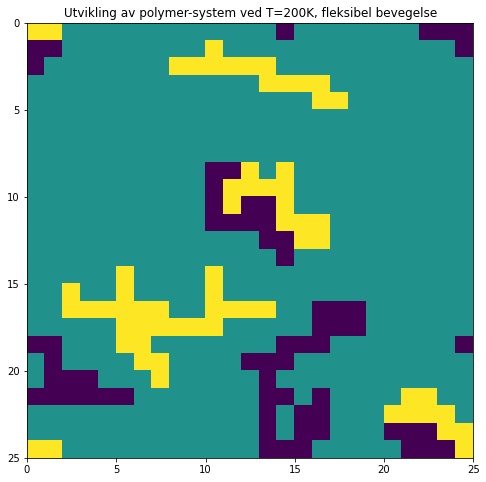

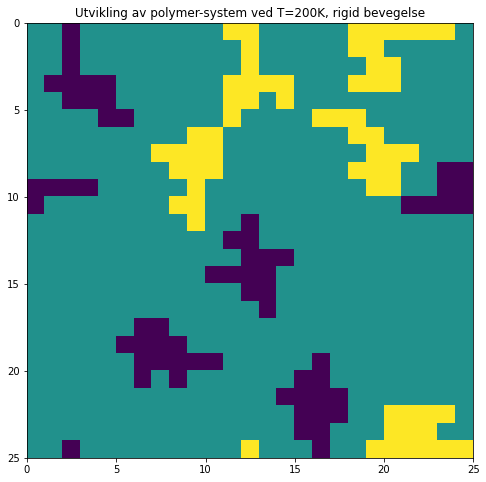

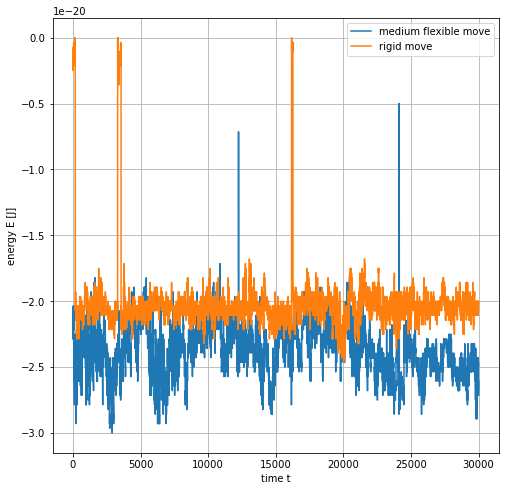

In [21]:
# Kjører en ny MC-simulasjon, samme parametre
N_s = 30000
N = 25            # Fritt valg
M = 5             # 2 < M < 6
L = 13            # L > 10
T = 200
# Benytter medium flexible move
grid_mc_flex, polymers_mc_flex, eps_mc_flex, grid_array_flex = monte_carlo_polymers(N_s,N,M,L,T,move_med_flex)
visualize_system(grid_mc_flex,13,"Utvikling av polymer-system ved T=200K, fleksibel bevegelse")
visualize_system(grid_mc_rigid,14,"Utvikling av polymer-system ved T=200K, rigid bevegelse")

# Plotter energiutviklingen over tid for begge simulasjonene i samme figur
plt.figure(15,figsize=(8,8))
t_energy = np.linspace(0, N_s, N_s)
plt.plot(t_energy, eps_mc_flex, label="medium flexible move")
plt.plot(t_energy, eps_mc_rigid, label="rigid move")
plt.xlabel('time t')
plt.ylabel('energy E [J]')
plt.grid(True)
plt.legend()
plt.show()

Til tross for at intitalsystemene for de to simulasjonene er ulike, oppdager vi ved gjentatte kjøringer av koden at polymersystemet som kan bevege seg med medium fleksibilitet vil stabilisere seg ved en lavere energi enn polymersystemet som kan bevege seg rigid. Dette skyldes at med mer fleksibilitet, kan polymerer av motsatt ladning oppnå flere interaksjonspunkter, som resulterer i en lavere totalenergi for systemet. Energidifferansen mellom systemene er likevel ikke betydelig stor, da vi ikke har implementert en bevegelse av full fleksibilitet, og polymersystemer i virkeligheten vil alså kunne oppnå enda lavere energi.

Som nevnt i introduksjon, er det væske-væske faseseparasjon som driver formeringen av membranløse organeller. De dråpe-liknende organellene består av en høy konsentrasjon av biopolymerer. Størrelsen av disse polymerene, som avhenger av multivalensen, påvirker grupperingene som oppstår, og dermed også formeringen av organeller. I vår siste simulasjon ønsker vi derfor å beregne to fysiske størrelsen relatert til faseseparasjonen, som en funksjon av multivalensen $L$; den gjennomsnittlige klynge-størrelsen delt på multivalensen, $\langle d \rangle$/$L$, og det gjennomsnittlige antallet grupperinger, $\langle m \rangle$. Hver gruppering vil her representere en organelle i cellen. Vi plotter størrelsene over 13 likefordelte verdier av $L$ mellom 3 og 39, og beregner størrelsene fra MC-simulasjoner ved bevegelser av medium fleksibilitet.

Fra MC-simulasjonen for et polymersystem som kan bevege seg med medium fleksibilitet, kan vi lese av fra figuren av energiutviklingen at systemet vil nå en likevektskonfigurasjon etter kun noen tusen MC-steg. For å være sikker på at systemet har nådd likevekt før vi begynner målingene, men uten at kjøretiden blir for lang, lar vi $t_{equil}=8000$. Jo flere målinger $n$ vi utfører, jo mer pålitelige blir resultatene våre, men jo lengre blir kjøretiden. Da figuren for energiutviklingen hinter til en smule mindre variasjon om likevektsverdien enn vi fikk for monomer-systemet, tillater vi oss en litt lavere verdi av antall målinger, og lar $n=20$.

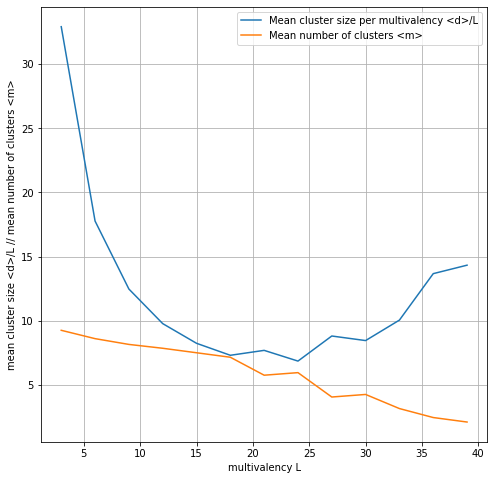

In [22]:
# Lager en egen count-funksjon, da list.count() ikke støttes av jit
@jit(nopython=True)
def count(element,seq):
    count = 0
    for i in seq:
        if  element == i:
            count += 1
    return count

# Funksjonen beregner gjennomsnittlig cluster-størrelse
@jit(nopython=True)
def mean_cluster_polymer_size(grid):
    N = len(grid[0])
    cluster_ids = np.zeros(N*N)
    k=0
    for i in range (N):
        for j in range(N):
            if grid[i,j] > 0:
                cluster_ids[k]=(grid[i,j]) 
                #k blir antall ganger loopen har iterert gjennom en polymerkoordinat
                k+=1
    different_cluster_ids = set(cluster_ids) #hvor mange forskjellige clustere det er
    antall_clusters = (len(different_cluster_ids))-1 #antall clustere totalt
    
    cluster_sizes = []
    sum_cluster_sizes = 0
    for element in different_cluster_ids:
        cluster_count = count(element,cluster_ids)
        cluster_sizes.append(cluster_count)
        sum_cluster_sizes += cluster_count
    return (sum_cluster_sizes/antall_clusters),antall_clusters

# Funksjonen beregner den middelverdige clusterstørrelsen 
# Estimeres å være lik "gjennomsnittet av gjennomsnittene"
@jit(nopython=True)
def total_mean_cluster_polymer_size():
    # Parameter-verdier vi benytter
    T = 300
    N = 30
    M = 5
    t_r = 1000
    t_equil = 8000 #valgt selv, kan endre
    n = 20 #valgt selv, kan endre
    L_array = np.linspace(3,39, 13)
    d = np.zeros((len(L_array),n))
    avg_d = np.zeros(len(L_array))
    m = np.zeros((len(L_array),n))
    avg_m = np.zeros(len(L_array))

    # Finner middelverdig clusterstørrelse for hver av temperaturene
    for q in range(len(L_array)):
        N_s = int(t_equil + t_r*n) # Totalt antall MC-steg
        grid_mc, eps_mc, polymers_mc, grid_array = monte_carlo_polymers(N_s,N,M,int(L_array[q]),T,move_med_flex,n,t_equil,t_r)
        for t in range(len(grid_array)):
            clustergrid_mc_step = cluster_gridv3(grid_array[t])
            d[q,t],m[q,t] = mean_cluster_polymer_size(clustergrid_mc_step)
        sum_d=0
        sum_m=0
        for x in range(len(d[q])): sum_d+=d[q,x]
        for y in range(len(m[q])): sum_m+=m[q,y]
        avg_d[q] = ((sum_d)/n)/(L_array[q])
        avg_m[q] = (sum_m)/n
    return L_array, avg_d, avg_m

L_array, avg_d, avg_m = total_mean_cluster_polymer_size()
# Plotter <d>/L og <m> mht. multivalensen
plt.figure(16,figsize=(8,8))
plt.plot(L_array, avg_d, label="Mean cluster size per multivalency <d>/L")
plt.plot(L_array, avg_m, label="Mean number of clusters <m>")
plt.xlabel('multivalency L')
plt.ylabel('mean cluster size <d>/L // mean number of clusters <m>')
plt.grid(True)
plt.legend()
plt.show()

Vi observerer at jo større multivalens $L$ vi har, jo færre gjennomsnittlig antall grupperinger $\langle m \rangle$ vil vi ha. Dette gir intuitivt mening, da større polymerer vil okkupere et større volum i gridet, og dermed ha mindre avstand til andre polymerer. Da øker sannsynligheten for at en bevegelse vil resultere i en lavere energi, ved at to polymerer av motsatt ladning møtes. Vi får dermed færre enkelt-polymerer, samt et høyere antall polymerer/monomerer per gruppering, og dermed et lavere gjennomsnittlig antall klynger. Et høyere antall polymerer/monomerer per gruppering vil også resultere i en økende verdi av $\langle d \rangle$/$L$, men denne effekten ser vi ikke før polymerene har oppnådd en proposjonalt stor nok $L$ i forhold til størrelsen $N$ på gridet. 

Ved rigid bevegelse vil vi få noe færre interaksjonspunkter, samt mindre tettpakning av polymerer, så da ville klyngene oppta større plass, og vi ville fått flere polymerer per klynge, og derfor en økt $\langle d \rangle$/$L$. Initialkonfigurasjonen vil også ha større betydning ved lavere $L$, da både $\langle m \rangle$ og $\langle d \rangle$/$L$ vil avhenge av hvor nærme de ulike polymerene befinner seg hverandre ved initialiseringen av systemet.

Til slutt vil vi vurdere hvordan de andre parameterene vil påvirke formeringen av aggregater/organeller. Et større system, altså en større $N$, vil resultere i større initiell avstand mellom polymerer, som gjør det vanskeligere for de kortrekkende elektrostatiske kreftene å påvirke systemet, og vi får et færre antall klynger. Jo høyere antall polymerer $M$ et system starter med, jo nærmere vil polymerene befinne seg hverandre, og jo økende antall klynger vil vi kunne få. Jo høyere temperatur $T$, jo mer sannsynlig er det at polymerene beveger seg i en energimessig ugunstig retning, og jo færre klynger vil resultere. Og sist, jo høyere gitterkonstant $a$ systemet har, jo mindre blir $\alpha$ som er proposjonal med energibidraget, som resulterer i en mindre $\Delta E$, og derfor en mindre sannsynlighet for energimessig ugunstige bevegelser, som igjen bidrar til flere klynger.

### Konklusjon

Vi har i dette prosjektet studert en numerisk tilnærming av egenskaper ved og oppførsel til systemer av monomerer og polymerer. Vi har fått et inntrykk av hvordan energiberegning, elektrostatiske krefter, temperatur og andre faktorer dikterer hvordan systemene vil utvikle seg over tid, og gruppere seg sammen til klynger som utgjør de livsviktige membranløse organellene en celle består av. Selv om vi har gjort enkelte antakelser og forenklinger, har dette prosjektet gitt oss et godt inntrykk av hva slags prosesser foregår på et mikroskopisk nivå, og hvordan vi kan utnytte numerikk og programmering for å studere og visualisere disse prosessene. 